In [47]:
from model_vae import CVAE, cvae_loss
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from vae_earlystopping import EarlyStopping
from torch.utils.data import  DataLoader, Dataset

x_data = np.load('./data/metal.npy',allow_pickle = True)
c_data = np.load('./data/reaction.npy',allow_pickle = True)
sup_data = np.load('./data/support.npy',allow_pickle=True)
x_dim = x_data.shape[1]
c_dim = c_data.shape[1]
sup_dim = sup_data.shape[1]


## 데이터 train,val,test 6:2:2로 일단 unshuffle로 나누기

In [3]:
## train,test,validation_data 만들기
from sklearn.model_selection import train_test_split
x_train,x_test,c_train,c_test = train_test_split(x_data,c_data,test_size = 0.4,shuffle = False)
x_val,x_test,c_val,c_test = train_test_split(x_test,c_test,test_size = 0.5,shuffle= False)
print(x_train.shape,c_train.shape,x_test.shape) #0.6 #0.2 #0.2로 데이터 분류


(3544, 24) (3544, 9) (1182, 24)


# 데이터 scaler로 정리하기

In [4]:
from sklearn.preprocessing import StandardScaler
scaler_x = StandardScaler()
scaler_c = StandardScaler()
x_train = scaler_x.fit_transform(x_train)
x_val = scaler_x.transform(x_val)
x_test = scaler_x.transform(x_test)
c_train = scaler_c.fit_transform(c_train)
c_val = scaler_c.transform(c_val)
c_test = scaler_c.transform(c_test)

In [5]:
x_train = torch.tensor(x_train, dtype=torch.float32)
x_val   = torch.tensor(x_val,   dtype=torch.float32)
x_test  = torch.tensor(x_test,  dtype=torch.float32)

c_train = torch.tensor(c_train, dtype=torch.float32)
c_val   = torch.tensor(c_val,   dtype=torch.float32)
c_test  = torch.tensor(c_test,  dtype=torch.float32)

## model에 넣고 학습시키기

In [6]:
model = CVAE(x_dim = x_dim,c_dim = c_dim,z_dim = 16)
x_hat,mu, logvar = model(x_train,c_train)
# x_hat = x_hat.detach().cpu().numpy()
# x_hat = scaler_x.inverse_transform(x_hat)
# x_hat = torch.tensor(x_hat, dtype=torch.float32)
cvae_loss(x_hat,x_train,mu,logvar,beta = -0.01)

(tensor(0.7185, grad_fn=<AddBackward0>),
 tensor(0.7195, grad_fn=<MseLossBackward0>),
 tensor(0.1002, grad_fn=<MeanBackward0>))

## 다시 inverse해서 구하는 방식

In [7]:
model = CVAE(x_dim = x_dim,c_dim = c_dim,z_dim = 16)
x_hat,mu, logvar = model(x_train,c_train)
x_hat = x_hat.detach().cpu().numpy()
x_hat = scaler_x.inverse_transform(x_hat)
x_hat = torch.tensor(x_hat, dtype=torch.float32)
cvae_loss(x_hat,x_train,mu,logvar,beta = -0.01)

(tensor(2.8811, grad_fn=<AddBackward0>),
 tensor(2.8821),
 tensor(0.1044, grad_fn=<MeanBackward0>))

In [8]:
from torch.utils.data import TensorDataset, DataLoader
batch_size = 64
learning_rate = 1e-3
z_dim = 16
epochs = 200
train_dataset = TensorDataset(x_train,c_train)
val_dataset = TensorDataset(x_val,c_val)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle = True)
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle = False)


In [34]:
%pip install torchsummary -q

Note: you may need to restart the kernel to use updated packages.


In [35]:
# 모델의 구조에 대한 생각
from torchsummary import summary

summary(model, input_size=[(x_dim,), (c_dim,)], device=str(device))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           4,352
            Linear-2                  [-1, 256]          33,024
            Linear-3                   [-1, 16]           4,112
            Linear-4                   [-1, 16]           4,112
            Linear-5                  [-1, 128]           3,328
            Linear-6                  [-1, 256]          33,024
            Linear-7                   [-1, 24]           6,168
Total params: 88,120
Trainable params: 88,120
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.34
Estimated Total Size (MB): 0.34
----------------------------------------------------------------


# 어떤 형태로 구성되어있나 생각하기

In [37]:
model_para = list(model.parameters())
for i in range(len(model_para))
    print(model_para[i].shape)

torch.Size([128, 33])
torch.Size([128])
torch.Size([256, 128])
torch.Size([256])
torch.Size([16, 256])
torch.Size([16])
torch.Size([16, 256])
torch.Size([16])
torch.Size([128, 25])
torch.Size([128])
torch.Size([256, 128])
torch.Size([256])
torch.Size([24, 256])
torch.Size([24])


## 학습방법

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 모델 초기화
model = CVAE(x_dim=x_dim, c_dim=c_dim, z_dim=z_dim).to(device)

# Optimizer 설정 (Adam이 일반적으로 가장 무난합니다)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [39]:
train_losses = []
val_losses = []

for epoch in range(1, epochs + 1):
    # --- 학습 모드 ---
    model.train()
    train_total_loss = 0
    
    for batch_x, batch_c in train_loader:
        batch_x, batch_c = batch_x.to(device), batch_c.to(device)
        
        optimizer.zero_grad() # 기울기 초기화
        
        # 순전파
        x_hat, mu, logvar = model(batch_x, batch_c)
        
        # 손실 계산 (beta 값을 조절하여 KL의 영향력을 제어할 수 있습니다)
        loss, recon, kl = cvae_loss(x_hat, batch_x, mu, logvar, beta=0.01)
        
        # 역전파 및 가중치 업데이트
        loss.backward()
        optimizer.step()
        
        train_total_loss += loss.item()
    
    avg_train_loss = train_total_loss / len(train_loader)
    
    # --- 검증 모드 (오차가 실제로 줄어드는지 확인) ---
    model.eval()
    val_total_loss = 0
    with torch.no_grad():
        for v_x, v_c in val_loader:
            v_x, v_c = v_x.to(device), v_c.to(device)
            v_hat, v_mu, v_logvar = model(v_x, v_c)
            v_loss, _, _ = cvae_loss(v_hat, v_x, v_mu, v_logvar,beta = 0.01)
            val_total_loss += v_loss.item()
            
    avg_val_loss = val_total_loss / len(val_loader)
    
    # 결과 저장 및 출력
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    if epoch % 20 == 0 or epoch == 1:
        print(f"Epoch [{epoch}/{epochs}] Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")
        

Epoch [1/200] Train Loss: 0.034818 | Val Loss: 1.239594
Epoch [20/200] Train Loss: 0.037858 | Val Loss: 4.342507
Epoch [40/200] Train Loss: 0.033752 | Val Loss: 1.301379
Epoch [60/200] Train Loss: 0.030199 | Val Loss: 1.326678
Epoch [80/200] Train Loss: 0.034133 | Val Loss: 1.429540
Epoch [100/200] Train Loss: 0.030179 | Val Loss: 1.471560
Epoch [120/200] Train Loss: 0.031295 | Val Loss: 1.380321
Epoch [140/200] Train Loss: 0.026931 | Val Loss: 1.560449
Epoch [160/200] Train Loss: 0.029265 | Val Loss: 1.585181
Epoch [180/200] Train Loss: 0.027634 | Val Loss: 1.587441
Epoch [200/200] Train Loss: 0.026815 | Val Loss: 2.687690


In [12]:
max(train_losses)

0.650792831821101

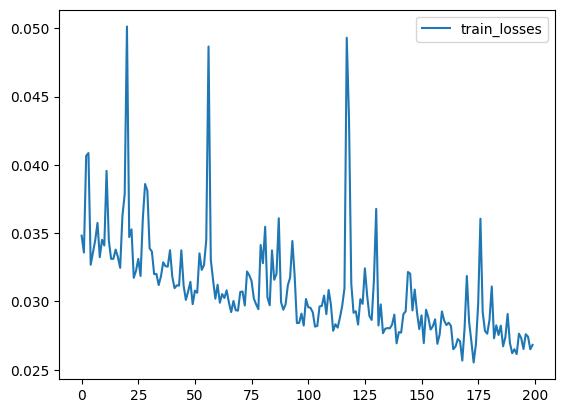

In [42]:
import matplotlib.pyplot as plt
x_value = np.arange(len(train_losses))
plt.plot(x_value,train_losses,label = 'train_losses')
# plt.plot(x_value,val_losses,label = 'val_losses')
plt.legend()
plt.show()

In [50]:
from torch.utils.data import TensorDataset, DataLoader

# (1) test_loader (x_test, c_test가 torch tensor로 만들어진 뒤에 실행)
test_loader = DataLoader(
    TensorDataset(x_test, c_test),
    batch_size=128,
    shuffle=False
)

train_losses = []
val_losses = []

early = EarlyStopping(patience=30, min_delta=1e-4)
best_epoch = 0

for epoch in range(1, epochs + 1):
    # --- 학습 ---
    model.train()
    train_total_loss = 0.0

    for batch_x, batch_c in train_loader:
        batch_x = batch_x.to(device)
        batch_c = batch_c.to(device)

        optimizer.zero_grad()
        x_hat, mu, logvar = model(batch_x, batch_c)

        loss, recon, kl = cvae_loss(x_hat, batch_x, mu, logvar, beta=0.01)

        loss.backward()
        optimizer.step()

        train_total_loss += loss.item()

    avg_train_loss = train_total_loss / len(train_loader)

    # --- 검증 ---
    model.eval()
    val_total_loss = 0.0
    with torch.no_grad():
        for v_x, v_c in val_loader:
            v_x = v_x.to(device)
            v_c = v_c.to(device)

            v_hat, v_mu, v_logvar = model(v_x, v_c)
            v_loss, _, _ = cvae_loss(v_hat, v_x, v_mu, v_logvar, beta=0.01)
            val_total_loss += v_loss.item()

    avg_val_loss = val_total_loss / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    if epoch % 20 == 0 or epoch == 1:
        print(f"Epoch [{epoch}/{epochs}] Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

    # --- EarlyStopping 체크 ---
    stop = early.step(avg_val_loss, model)
    if early.best_state is not None and avg_val_loss == early.best:
        best_epoch = epoch

    if stop:
        print(f"Early stopping at epoch {epoch}. Best epoch: {best_epoch}, Best val loss: {early.best:.6f}")
        break

# ===== 학습 끝: best 모델 weight로 복원 =====
if early.best_state is not None:
    model.load_state_dict(early.best_state)
model = model.to(device)
model.eval()

# ===== (2) 그 상태에서 prediction =====
x_hat_list = []
mu_list = []
logvar_list = []

with torch.no_grad():
    for x_t, c_t in test_loader:
        x_t = x_t.to(device)
        c_t = c_t.to(device)

        x_hat, mu, logvar = model(x_t, c_t)

        x_hat_list.append(x_hat.detach().cpu())
        mu_list.append(mu.detach().cpu())
        logvar_list.append(logvar.detach().cpu())

x_hat_test = torch.cat(x_hat_list, dim=0)     # (N_test, x_dim)
mu_test = torch.cat(mu_list, dim=0)           # (N_test, z_dim)
logvar_test = torch.cat(logvar_list, dim=0)   # (N_test, z_dim)

print("x_hat_test shape:", x_hat_test.shape)

# (선택) test recon MSE 확인
x_true_test = x_test.detach().cpu()
test_mse = F.mse_loss(x_hat_test, x_true_test).item()
print("test recon MSE:", test_mse)


Epoch [1/200] Train Loss: 0.031239 | Val Loss: 3.501015
Epoch [20/200] Train Loss: 0.027388 | Val Loss: 1.539720
Epoch [40/200] Train Loss: 0.024966 | Val Loss: 2.302677
Early stopping at epoch 50. Best epoch: 20, Best val loss: 1.539720
x_hat_test shape: torch.Size([1182, 24])
test recon MSE: 1.8301879167556763


In [64]:
x_true_test_np = x_true_test.detach().cpu().numpy()
x_test_np = x_hat_test.detach().cpu().numpy()
x_true_test = scaler_x.inverse_transform(x_true_test_np)
x_hat_test = scaler_x.inverse_transform(x_test_np)

In [70]:
x_true_test = x_true_test.flatten()

(1182, 24) (1182, 24)


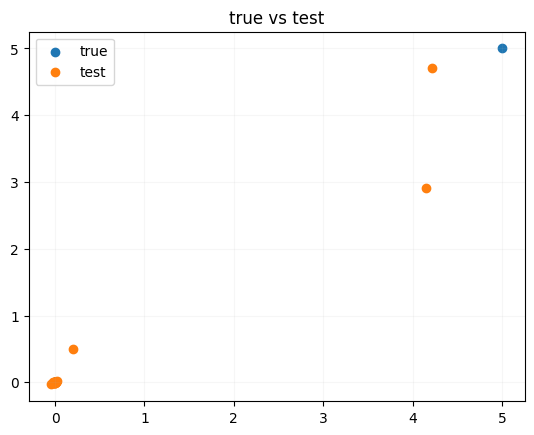

In [68]:
print(x_true_test.shape,x_true_test.shape)
plt.scatter(x_true_test[0],x_true_test[1],label = 'true')
plt.scatter(x_hat_test[0],x_hat_test[1], label = 'test')
plt.legend()
plt.grid(alpha =0.1)
plt.title('true vs test')
plt.show()